In [1]:
from train import *
from params import TrainingParams
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

Using TensorFlow backend.


In [2]:
params = TrainingParams()
params.train_path='data/train/val2017/*.jpg'
params.style_path='data/starry_night.jpg'
params.batch_size = 1
params.num_epoch = 2
params.learn_rate = 0.001
params.total_train_sample = 4

In [ ]:
def report_loss(batch, epoch, total_cost):
    cost_history.append(total_cost)
    plt.plot(cost_history)
    display.display(plt.gcf())
    display.clear_output(wait=True)

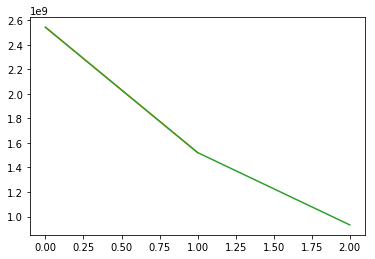

In [ ]:
cost_history = []
train(params, report_fn=report_loss)